In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Efficiency calculations
## To reuse this script
Change:
- the data files for the efficiency and time data, as well as the background data if you have it
- n to the number of vials
- c to the radiation concentration of the original solution
- c_time to the time and date when the above concentration was measured

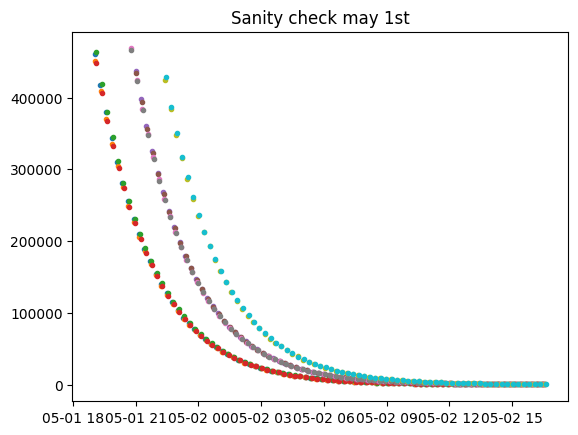

In [77]:
data = np.genfromtxt("efficiency_set4.csv", delimiter=",", skip_header=1, usecols=[3, 6, 8], encoding="utf8")
# shape: mass of sample, deadtime factor, CPM
time = np.genfromtxt("efficiency_set4.csv", delimiter=",", skip_header=1, usecols=[4], encoding="utf8", dtype='datetime64')
n = 10 # number of vials
N = np.shape(data)[0]/n # number of measurements per vial (i.e. number of Hidex files)

#m = data[:n,0] # masses of the n vials -- note: these are masses measured by the Hidex, and they're not so good for this dataset
mass_data = np.genfromtxt("mass_comparison.csv", delimiter=",", skip_header=1, encoding="utf8")
m = mass_data[:,5]
masses = np.tile(m, int(N)) # match masses to number of runs

# remove the parts of the data where the deadtime factor is >1.1
data[data[:,1]>1.1,2] = np.nan

# subtract the background
bg = 41
data[:,2] = data[:,2] - bg

plt.figure()
plt.title("Sanity check may 1st")
for i in range(0, 10):
    plt.plot(time[i::n], data[i::n, 2], ".")
plt.show()

In [78]:
time_in_seconds = time.astype('datetime64[s]').astype('int')

# calculate the concentrations in the samples in CPM/ml (assuming 1g/ml)
conc = data[:,2]/masses

c = 0.0679/19.019 # mCi/ml, original concentration of the solution
c_time = np.datetime64('2024-05-01T17:35:00') # original time of measurement for the above concentration
c_time_in_seconds = c_time.astype('datetime64[s]').astype('int')

time_in_seconds = time_in_seconds - c_time_in_seconds # start the timer at the time of normalization

def decay(A0, t, h=109.7*60):
    # input t must be in seconds
    return A0*2**(-t/h)

# this is the theoretical concentration of radiation for each measurement in mCi/ml
ref = decay(c, time_in_seconds)


# calculate the efficiency
efficiency = conc/ref # in CPM/mCi
efficiency = efficiency * 1000 / (3.7e10 * 60) *100 # transform the cpm such that we get mCi/mCi

ref_activity = ref*masses*1000 # theoretical activity in tubes in uCi

[-2.73665278 34.21598271]
[[ 0.08689494 -0.0072352 ]
 [-0.0072352   0.0023225 ]]


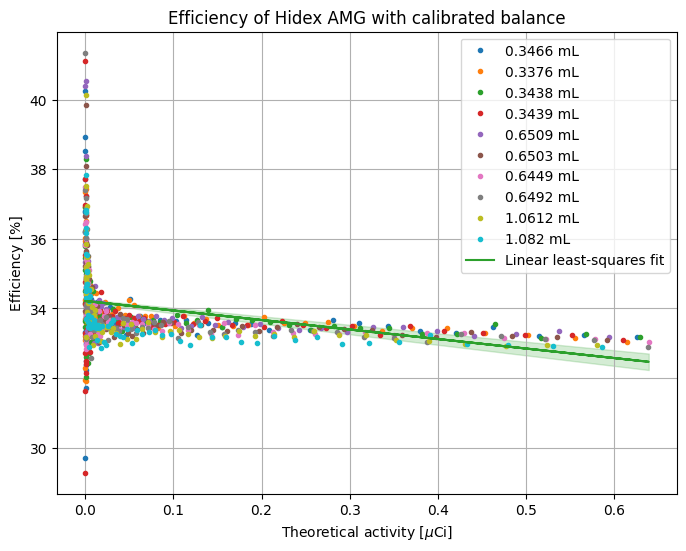

In [81]:
# plotting
plt.figure(figsize=(8,6))
plt.title("Efficiency of Hidex AMG with calibrated balance")
plt.ylabel("Efficiency [%]")
plt.xlabel(r"Theoretical activity [$\mu$Ci]")

for i in range(0, 10):
    plt.plot(ref_activity[i::n], efficiency[i::n], ".", label=str(data[i, 0]) + " mL")
    
#plt.xlim(0, 0.001)

#plt.xscale('log')
plt.grid()
x = ref_activity[np.isfinite(efficiency)]
y = efficiency[np.isfinite(efficiency)]

b, cov = np.polyfit(x, y, 1, cov = True)
print(b)
print(cov)
plt.plot(x, x*b[0] + b[1], color='C2', label="Linear least-squares fit")
perr = np.sqrt(np.diag(cov))

x = np.linspace(0, max(x), 126)
y_plus = (b[0]+perr[0])*x + b[1]+perr[1]
y_minus = (b[0]-perr[0])*x + b[1]-perr[1]
plt.fill_between(x, y_minus, y_plus, alpha=0.2, color='C2')

plt.legend()

# Mass of the Hidex

This section explores the differences in mass measurements between the Hidex and a fancy balance from the chemistry lab.

- Looks like the hidex tends to underestimate measurements by up to 0.05 g

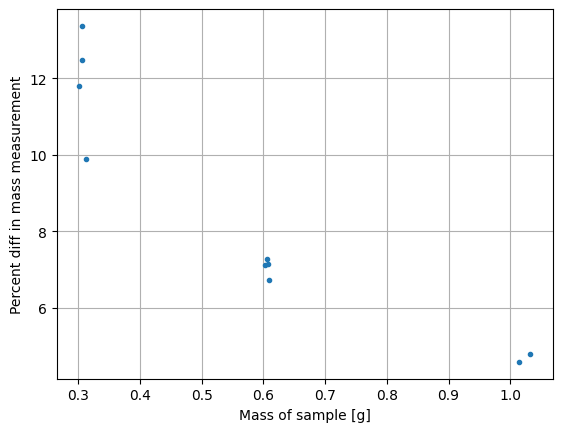

In [87]:
mass_data = np.genfromtxt("mass_comparison.csv", delimiter=",", skip_header=1, encoding="utf8")

plt.plot(mass_data[:,5], (mass_data[:,2]-mass_data[:,5])/mass_data[:,5] * 100,  ".")
plt.xlabel("Mass of sample [g]")
plt.ylabel("Percent diff in mass measurement")
plt.grid()